In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab/diffusion/generative-inverse-heat-dissipation
#%cd /content/drive/MyDrive/diffusion/generative-inverse-heat-dissipation

/content/drive/MyDrive/Colab/diffusion/generative-inverse-heat-dissipation


In [3]:
from pathlib import Path
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader,ConcatDataset
from torchvision.utils import make_grid
import numpy as np

In [4]:
def show_batch_imgs(imgs,nrow=4):
    img_grid = make_grid(imgs,nrow=nrow,padding=2)
    img_tmp = torchvision.transforms.ToPILImage()(img_grid)
    display(img_tmp) # img_tmp.show()
    #fig=plt.figure()
    #fig.set_size_inches(1,8)
    #plt.imshow(img_grid.permute(1,2,0))
    #plt.axis('off')
    #plt.show()
    return

In [5]:
def min_max_norm_image(x:torch.tensor):
    """
    Returns the min-max normalization per image in the
    batch instead of over the entire batch of images.
    """
    b = x.shape[0]
    x_min = x.view(b, -1).min(dim=1).values[:, None, None, None]
    x_max = x.view(b, -1).max(dim=1).values[:, None, None, None]
    return (x - x_min) / (x_max - x_min)

In [6]:
# angle=0 # 0 , 3, 5 , 10 , 30 , 90 , 180
# tf = transforms.Compose(
#     [transforms.RandomRotation(degrees=(90, 90)),transforms.ToTensor()] #, transforms.Normalize((0.5,), (0.5,)) #RandomRotation(degrees=(0, 180)) RandomRotation(angle)
# )
tf = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)

dataset_train = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=tf,
)
dataset_test = CIFAR10(
    "./data",
    train=False,
    download=True,
    transform=tf,
)
print(f'len(dataset_train)={len(dataset_train)},len(dataset_test)={len(dataset_test)}')
dataset = ConcatDataset([dataset_train,dataset_test])
print('ConcatDataset length =',len(dataset))

Files already downloaded and verified
Files already downloaded and verified
len(dataset_train)=50000,len(dataset_test)=10000
ConcatDataset length = 60000


In [7]:
dataset_split_len=12000#12000 #50000,60000
rndsampler=torch.randint(1,len(dataset),size=(dataset_split_len,))
#torch.save(rndsampler,f'./rndsampler_{dataset_split_len}.pt')
#rndsampler=torch.load(f'./rndsampler_{dataset_split_len}.pt')
dataloader = DataLoader(dataset, batch_size=128, sampler=rndsampler)
print('len(dataloader)=',len(dataloader))

len(dataloader)= 94


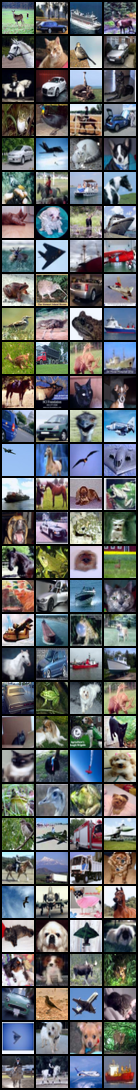

In [8]:
imgs_labels=next(iter(dataloader))
imgs_,labels_ = imgs_labels[0],imgs_labels[1]
show_batch_imgs(min_max_norm_image(imgs_))

In [41]:
imglist=[]
for batch,label in dataloader:
    x = min_max_norm_image(batch) # between [0,1]
    x = (x * 255).clamp(0,255).to(torch.uint8)
    x = x.permute(0,2,3,1)
    x = x.contiguous()
    imglist.append(x.cpu().numpy())

imglist=np.concatenate(imglist,axis=0)
ref_path=f'./ref_batch/cifar_dataset_{dataset_split_len}.npz' #
np.savez(ref_path,imglist)
print('imglist save in to :',ref_path)

imglist save in to : ./ref_batch/cifar_dataset_50000.npz


In [42]:
ref_path = f'./ref_batch/cifar_dataset_{dataset_split_len}.npz'
arr=np.load(ref_path)
arr.files

['arr_0']

In [9]:
ref_path = f'./ref_batch/fid_stats_cifar10_train.npz'
arr=np.load(ref_path)
arr.files


['mu', 'sigma']

In [11]:
arr['mu'].shape

(2048,)

In [43]:
arr['arr_0'].shape

(50000, 32, 32, 3)

In [11]:
np.min(arr['arr_0'][46]),np.max(arr['arr_0'][46])

(0, 255)

In [ ]:
from PIL import Image
import os
def npz_to_png(npz_path,dir_path):
    # Load the .npz file
    data = np.load(npz_path)
    # Extract the image data from the .npz file
    image_data = data['arr_0']

    for i in range(20): # for each image ,image_data.shape[0]
        image = image_data[i,:,:,:]
        image = Image.fromarray(image)
        path = os.path.join(dir_path, f"{str(i)}.png")
        image.save(path)

In [ ]:
png_dir = os.path.join("./ref_batch", "png_cifar_10000_100")
print(png_dir)
Path(png_dir).mkdir(parents=True, exist_ok=True)
npz_to_png(ref_path,png_dir)

./ref_batch/png_cifar_10000_100


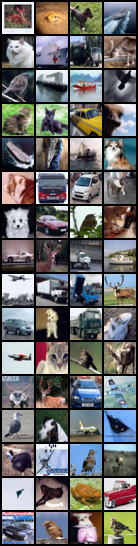

In [ ]:
import matplotlib.pyplot as plt

x=arr['arr_0'][:64] # NWHC
x=torch.from_numpy(x.transpose(0,3,1,2)) #NCWH
show_batch_imgs(x)